### NPSC psudeo-extension stands for NuPlan Scenario Collection. 
#### It is a pkl file with the naming convention `filename.npsc.pkl` that contains:
* The data structure of a dictionary of scenario modifications.
* The `DATASET_PARAMS` list of filters in order to extract the correct scenarios to modify.

In [1]:
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()

import torch

torch.cuda.is_available()

import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [2]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [3]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [4]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [5]:
import pickle

EXPERIMENT_NAME = "pdm_closed_pdm_closed_cross_pure_scen_20"
modification_file_path = "npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl"
with open(modification_file_path, "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(list(mod_list_dict.keys()))
    DATASET_PARAMS = pickle.load(output_file)

print(DATASET_PARAMS)

['33488d1c844c5428', 'a1aef53dcf0a5e43', '895bf97a81b65c5b', '8fb31d539eff54f7', 'e72f1ff10a7758b9', '911afc3674645ac7', 'e19110381bdb5fb2', 'fd2cd894bd565a95', '4298e30c9c2453be']
['scenario_builder=val', 'scenario_filter=all_scenarios', "scenario_filter.scenario_types=['starting_left_turn', 'starting_right_turn', 'starting_straight_stop_sign_intersection_traversal', 'starting_straight_traffic_light_intersection_traversal', 'starting_unprotected_cross_turn', 'starting_unprotected_noncross_turn', 'traversing_intersection', 'traversing_traffic_light_intersection']", 'scenario_filter.ego_displacement_minimum_m=10', 'scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]', 'scenario_filter.num_scenarios_per_type=100']


In [6]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'

In [7]:
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",
        "+occlusion_cfg.notice_threshold=1.0",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+modification_file_path={modification_file_path}",
        # "+remove_other_agents=true",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ################################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')

default_simulation


output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.13.10.12.36"


### Now, we run the simulations

In [8]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-05-13 10:12:36,294 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-05-13 10:12:36,330 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-05-13 10:12:37,949	INFO worker.py:1636 -- Started a local Ray instance.


2024-05-13 10:12:38,630 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-05-13 10:12:38,631 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-05-13 10:12:38,631 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-05-13 10:12:38,631 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-05-13 10:12:38,631 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.13.10.12.36

2024-05-13 10:12:38,633 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]
(raylet) [2024-05-13 10:12:47,924 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504491642880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:12:57,926 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504497336320; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-05-13 10:13:00,704 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:83}  Building metric engines...
2024-05-13 10:13:00,841 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:85}  Building metric engines...DONE
2024-05-13 10:13:00,841 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:89}  Building simulations from 697 scenarios...


(raylet) [2024-05-13 10:13:07,929 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504497336320; capacity: 16125711347712. Object creation will fail if spilling is required.


2024-05-13 10:13:09,639 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:151}  Modyfing Scenarios...
[
	'33488d1c844c5428',
	'4298e30c9c2453be',
	'895bf97a81b65c5b',
	'8fb31d539eff54f7',
	'911afc3674645ac7',
	'a1aef53dcf0a5e43',
	'e19110381bdb5fb2',
	'e72f1ff10a7758b9',
	'fd2cd894bd565a95'
]
2024-05-13 10:13:09,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:206}  Created 22 modified scenarios from 697 scenarios, 9 of which were modifiable.
2024-05-13 10:13:09,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:207}  Building simulations...DONE!
2024-05-13 10:13:09,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-05-13 10:13:09,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-05-13 10:13:09,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/s

Ray objects:   0%|          | 0/22 [00:00<?, ?it/s](raylet) [2024-05-13 10:13:17,936 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504497225728; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:13:27,942 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504497205248; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:13:37,948 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504497168384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:13:47,955 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% ful

2024-05-13 10:15:29,045 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 22
2024-05-13 10:15:29,046 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-05-13 10:15:29,046 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-05-13 10:15:29,056 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.13.10.12.36/runner_report.parquet
2024-05-13 10:15:29,056 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:02:52 [HH:MM:SS]
2024-05-13 10:15:29,379 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-05-13 10:15:29,449 

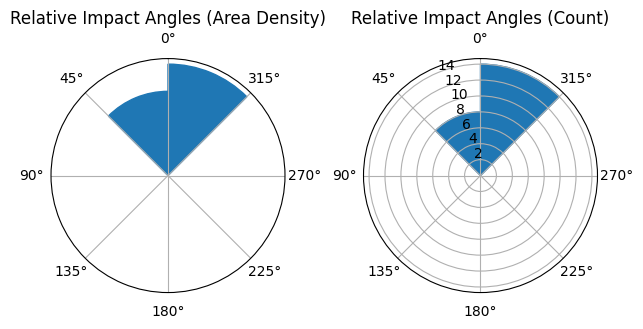

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vis_utils import circular_hist

%matplotlib inline

# # seq
# output_folder_occ_s = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.27.19"
# )
# #cross
# output_folder_occ_c = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.37.26"
# )
# #merge
# output_folder_occ_m = (
#   "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.42.37"
# )
# #diverge
# output_folder_occ_d = (
#   "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.45.40"
# )

file_path = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path)
relative_angles_of_impact_df = df[
    "relative_impact_angle_at_first_ego_collision_with_vehicles_stat_value"
]
relative_angles_of_impact = relative_angles_of_impact_df.to_numpy()

# fig, ax = plt.subplots(1, 2)
# fig.tight_layout()
figp, axp = plt.subplots(1, 2, subplot_kw=dict(projection="polar"))
figp.tight_layout()

# Visualise by area of bins
circular_hist(
    axp[0],
    relative_angles_of_impact,
    bins=8,
    density=True,
    offset=np.pi / 2,
    gaps=False,
)

circular_hist(
    axp[1],
    relative_angles_of_impact,
    bins=8,
    density=False,
    offset=np.pi / 2,
    gaps=False,
)


axp[0].title.set_text("Relative Impact Angles (Area Density)")
axp[1].title.set_text("Relative Impact Angles (Count)")

In [10]:
path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print("num : ", len(scenario_list))
for item in scenario_list:
    print(item)

num :  22
list :  ['33488d1c844c5428_sequential_conflict_injection_and_occlusion_injection_1', 'a1aef53dcf0a5e43_sequential_conflict_injection_and_occlusion_injection_0', '895bf97a81b65c5b_sequential_conflict_injection_and_occlusion_injection_2', '8fb31d539eff54f7_sequential_conflict_injection_and_occlusion_injection_0', 'e72f1ff10a7758b9_sequential_conflict_injection_and_occlusion_injection_3', '911afc3674645ac7_sequential_conflict_injection_and_occlusion_injection_1', '895bf97a81b65c5b_sequential_conflict_injection_and_occlusion_injection_4', 'e72f1ff10a7758b9_sequential_conflict_injection_and_occlusion_injection_1', 'e19110381bdb5fb2_sequential_conflict_injection_and_occlusion_injection_0', 'fd2cd894bd565a95_sequential_conflict_injection_and_occlusion_injection_1', '895bf97a81b65c5b_sequential_conflict_injection_and_occlusion_injection_3', '4298e30c9c2453be_sequential_conflict_injection_and_occlusion_injection_0', '33488d1c844c5428_sequential_conflict_injection_and_occlusion_injecti

In [11]:
import re

output_folder = [output_folder_occ]

print(output_folder_occ)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)
scenario_builder = None
for item in DATASET_PARAMS:
    parts = re.split("=", item, 1)
    if parts[0] == "scenario_builder":
        scenario_builder = parts[1]
if scenario_builder is None:
    raise ValueError("scenario_builder not specified in the dataset parameters")
print(scenario_builder)
# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.13.10.12.36
val


### Launch NuBoard

In [12]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-05-13 10:15:30,286 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-05-13 10:15:30,303 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-05-13 10:15:30,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-05-13 10:15:30,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-05-13 10:15:30,304 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-05-13 10:15:30,304 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

2024-05-13 10:15:32,374 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-05-13 10:15:32,384 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0006 seconds.
2024-05-13 10:15:32,484 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 447.25ms
2024-05-13 10:15:32,538 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre.min.css (127.0.0.1) 2.60ms
2024-05-13 10:15:32,550 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.33ms


INFO:tornado.access:200 GET / (127.0.0.1) 447.25ms
INFO:tornado.access:200 GET /resource/spectre.min.css (127.0.0.1) 2.60ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (127.0.0.1) 0.33ms


2024-05-13 10:15:33,493 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.43ms
2024-05-13 10:15:33,494 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-05-13 10:15:33,494 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2024-05-13 10:15:33,625 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-05-13 10:15:33,635 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0006 seconds.


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.43ms


2024-05-13 10:15:33,728 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 227.14ms


INFO:tornado.access:200 GET / (127.0.0.1) 227.14ms
(raylet) [2024-05-13 10:15:38,004 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504061468672; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:15:48,006 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504061337600; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:15:58,008 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504061329408; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:16:08,010 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% ful

2024-05-13 10:18:48,962 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.8999 seconds.


(raylet) [2024-05-13 10:18:58,045 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060944384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:19:08,047 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060944384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:19:18,049 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060940288; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:19:28,051 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060932096; capacity: 1612571

2024-05-13 10:21:23,236 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.5868 seconds.


(raylet) [2024-05-13 10:21:28,077 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060583936; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:21:38,079 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060559360; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:21:48,081 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060424192; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:21:58,083 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060416000; capacity: 1612571

2024-05-13 10:24:02,367 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 4.9399 seconds.


(raylet) [2024-05-13 10:24:08,110 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060186624; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:24:18,112 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060186624; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:24:28,114 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060186624; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:24:38,116 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504060153856; capacity: 1612571

2024-05-13 10:25:45,708 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.2187 seconds.


(raylet) [2024-05-13 10:25:48,130 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059973632; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:25:58,132 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059969536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:26:08,134 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059965440; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:26:18,136 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059965440; capacity: 1612571

2024-05-13 10:27:39,993 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.9692 seconds.


(raylet) [2024-05-13 10:27:48,153 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059752448; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:27:58,155 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059748352; capacity: 16125711347712. Object creation will fail if spilling is required.
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 90.36it/s]


2024-05-13 10:28:02,201 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.5565 seconds.


(raylet) [2024-05-13 10:28:08,157 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059744256; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:28:18,159 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059744256; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:28:28,161 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059744256; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:28:38,163 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059715584; capacity: 1612571

2024-05-13 10:28:51,996 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.1856 seconds.


(raylet) [2024-05-13 10:28:58,167 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059576320; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:29:08,169 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059568128; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:29:18,171 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059568128; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:29:28,173 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504059559936; capacity: 1612571

2024-05-13 10:46:45,179 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.9445 seconds.


(raylet) [2024-05-13 10:46:48,505 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057589760; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:46:58,508 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057585664; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:47:08,511 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057585664; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:47:18,515 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057585664; capacity: 1612571

2024-05-13 10:47:40,129 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.1120 seconds.


(raylet) [2024-05-13 10:47:48,525 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057409536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:47:58,529 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057409536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:48:08,532 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057409536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:48:18,535 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057405440; capacity: 1612571

2024-05-13 10:49:08,217 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.7301 seconds.


(raylet) [2024-05-13 10:49:08,553 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057360384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:49:18,555 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057360384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:49:28,557 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057360384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:49:38,558 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057221120; capacity: 1612571

2024-05-13 10:49:50,776 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.9407 seconds.


(raylet) [2024-05-13 10:49:58,562 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057196544; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:50:08,564 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057188352; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:50:18,566 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057188352; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:50:28,568 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057184256; capacity: 1612571

2024-05-13 10:50:38,460 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.5603 seconds.


(raylet) [2024-05-13 10:50:38,570 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057155584; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:50:48,572 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057151488; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:50:58,574 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057147392; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:51:08,577 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504057143296; capacity: 1612571

2024-05-13 10:51:53,275 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.2235 seconds.


(raylet) [2024-05-13 10:51:58,587 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056975360; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:52:08,590 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056971264; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:52:18,593 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056967168; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:52:28,597 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056967168; capacity: 1612571

2024-05-13 10:52:55,176 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.3653 seconds.


(raylet) [2024-05-13 10:52:58,607 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056930304; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:53:08,611 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056926208; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:53:18,615 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056922112; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:53:28,617 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056922112; capacity: 1612571

2024-05-13 10:54:48,111 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.9763 seconds.


(raylet) [2024-05-13 10:54:48,634 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056700928; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:54:58,636 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056696832; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:55:08,638 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056692736; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:55:18,640 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056692736; capacity: 1612571

2024-05-13 10:58:15,895 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.5377 seconds.


(raylet) [2024-05-13 10:58:18,697 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056303616; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:58:28,700 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056303616; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:58:38,704 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056139776; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:58:48,707 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056135680; capacity: 1612571

2024-05-13 10:59:31,362 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.2601 seconds.


(raylet) [2024-05-13 10:59:38,726 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056098816; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:59:48,729 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056094720; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 10:59:58,733 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056090624; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:00:08,736 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504056090624; capacity: 1612571

2024-05-13 11:00:46,646 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.6550 seconds.


(raylet) [2024-05-13 11:00:48,750 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055918592; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:00:58,753 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055922688; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:01:08,756 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055914496; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:01:18,760 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055910400; capacity: 1612571

2024-05-13 11:01:37,174 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.5793 seconds.


(raylet) [2024-05-13 11:01:38,768 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055877632; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:01:48,770 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055873536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:01:58,773 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055873536; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:02:08,777 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055869440; capacity: 1612571

2024-05-13 11:02:41,436 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.8880 seconds.


(raylet) [2024-05-13 11:02:48,790 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055701504; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:02:58,793 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055693312; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:03:08,796 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055693312; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:03:18,800 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055693312; capacity: 1612571

2024-05-13 11:04:04,763 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.5586 seconds.


(raylet) [2024-05-13 11:04:08,818 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055652352; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:04:18,821 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055648256; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:04:28,824 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055648256; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:04:38,828 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055488512; capacity: 1612571

2024-05-13 11:05:26,475 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.3855 seconds.


(raylet) [2024-05-13 11:05:28,845 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055463936; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:05:38,848 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055435264; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:05:48,852 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055427072; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:05:58,855 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055427072; capacity: 1612571

2024-05-13 11:06:09,810 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 5.4549 seconds.


(raylet) [2024-05-13 11:06:18,862 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055418880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:06:28,865 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055418880; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:06:38,868 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055255040; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-13 11:06:48,872 E 323103 323115] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-13_10-12-36_357405_322805 is over 95% full, available space: 504055255040; capacity: 1612571